In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,dct
from tensorflow.keras.datasets import mnist
from scipy.sparse import random
from keras import layers
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras import backend as K
from sklearn.linear_model import OrthogonalMatchingPursuit
import time
import cvxpy as cp

Schematic flow:
X' is sparse matrix

      X  --Tranform-->   FX  -->  Y = (AFX + noise) --> Neural Network -->  FX'   --Tranform-->  X' --Thresholding-->  X'_thresh

Clarifications: Y is the input to NN X is the output. X and Y are governed by  the equation: Y= AX +B  ,where B is noise

In [ ]:
# Initializations
dimension = 100
equations = 50
A = np.random.rand(equations,dimension)
n = 10000 # no of points to generate
eval_n = 5000 #points to eval/validate model on
test_n = 5000 #testing
mu = 0
test_sigma = 0.2 # mean and std dev for gaussian noise for testing noise , usually kept high
train_sigma = 0.01
min_freq= 0.1
max_freq = 20 #make sure this is not >= dimension/5
num_of_waves = 10
cardinality = 10
multiplier =1
# print(A)

In [ ]:
#generating db
def generate_db(mu,sigma,A,dimension,equations,n):
  x = np.empty((n,dimension), dtype = np.float32)
  y = np.empty((n,equations), dtype = np.float32)
  for i in range(n):
    tempx = np.random.rand(dimension)
    noise = np.random.normal(mu, sigma, [equations]) 
    tempy = np.matmul(A,tempx) + noise
    x[i] = tempx
    y[i] = tempy
  return x,y
# This is a non vectorized version for sine wave generation, so slow, use when debugging
# def generate_db_sine(mu,sigma,A,dimension,equations,n,min_freq = 0.1,max_freq=20,k=1):
#   Fs = dimension
#   time = np.arange(Fs)/Fs
#   x = np.empty((n,dimension), dtype = np.float32)
#   y = np.empty((n,equations), dtype = np.float32)
#   for i in range(n):
#     f = 13.34935244#np.random.uniform(min_freq,max_freq)
#     phi = np.random.uniform(0,2*np.pi)
#     tempx= np.sin((2 * np.pi * f * time / Fs)+phi)
#     noise = np.random.normal(mu, sigma, [equations]) 
#     tempy = np.matmul(A,tempx) + noise
#     x[i] = tempx
#     y[i] = tempy
#   return x,y,f

def generate_db_sine(mu,sigma,A,dimension,equations,n,min_freq = 0.1,max_freq=20):
  Fs = dimension
  time = np.arange(Fs).reshape(1,Fs)/Fs
  f = np.random.uniform(min_freq,max_freq,(n,1))
  # print(f[9])
  phi = np.random.uniform(0,2*np.pi,(n,1))
  datx = np.cos(((np.outer(time,f)*2*np.pi).T)).T
  noise = np.random.normal(mu, sigma, (equations,n))
  daty = np.matmul(A,datx)+noise
  return datx.T,daty.T

def generate_db_sine_multiple(mu,sigma,A,dimension,equations,n,min_freq = 0.1,max_freq=20,k=1):
  x = np.zeros((n,dimension), dtype = np.float32)
  y = np.zeros((n,equations), dtype = np.float32)
  for i in range(k):
    x1,y1 = generate_db_sine(mu,sigma,A,dimension,equations,n,min_freq,max_freq)
    x = np.add(x,x1)
    y = np.add(y,y1)
  return x,y
  
def generate_db_sparse(mu,sigma,num_of_waves,dimension,equations,n,A,cardinality):
  
  x = np.zeros((n,dimension), dtype = np.float32)
  y = np.zeros((equations,n,dimension+1), dtype = np.float32)
  y_unmodified = np.zeros((n,equations), dtype = np.float32)
  # sums = np.sum(A,axis =1)
  # print(len(sums),"sums ",sums )
  # A1 = np.reshape(A,(1,dimension*equations))
  # temp = np.ones(n)
  # temp = np.reshape(temp,(n,1))
  # temp = temp*A1
  # print(temp.shape)
  for i in range(n):
    """
    #SPaRSE
    x[i] = ((random(1, dimension, density=num_of_waves/dimension).A))
    temp = (x[i]>0).astype(int)
    x[i] = (x[i]*cardinality).astype(int)
    """

    #SiNE
    min_f = 0.1
    max_f = num_of_waves
    Fs = dimension
    time = np.arange(Fs).reshape(1,Fs)/Fs
    f = np.random.uniform(max_f-20,max_f)
    phi = np.random.uniform(0,2*np.pi)
    x[i] = np.cos(time*f*2*np.pi)
    # x[i] = np.reshape(x[i],(dimension,1))
    # x=(x>0).astype(int);
    
    noise = np.random.normal(mu, 0, (equations))
    y_temp = np.matmul(A,x[i].T)+noise
    # print(y_temp)
    # y_temp = np.divide(y_temp,sums)
    # print(y_temp)
    y_unmodified[i]= y_temp
    y_temp = y_temp.reshape((equations,1))
    # print(x[i].shape,noise.shape,y_temp.shape) 
    # print(y_temp)
    mesa_t = np.append(A,y_temp,axis =1)
    flattened = np.reshape(mesa_t,(equations*(dimension+1)))
    for j in range(equations):
      y[j][i]= flattened[j*(dimension+1):(j+1)*(dimension+1)]

  y_ret = []
  for j in range(equations):
    y_ret.append(y[j])
    # print(temp)
  # print(A)
  #--------
  # x=(x>0).astype(int);
  x= x*multiplier
  # x = x-1
  # y = np.concatenate((y.T,temp),axis =1)
  # print(x,y)
  return y_unmodified,x,y_ret;
  # To save into csv 
  # with open('dbx', 'wb') as dbx:
  #   np.save(dbx,x)

  # with open('dby', 'wb') as dby:
  #   np.save(dby,y)

(2, 100) 50 2 101 2 50
[ 1.          0.81749785  0.33660537 -0.2671495  -0.77339363 -0.99734575
 -0.8572623  -0.40427437  0.19627544  0.7251839   0.98939705  0.89247596
  0.46979728 -0.12435947 -0.67312443 -0.9761961  -0.9229519  -0.53282624
  0.05178331  0.6174917   0.95781296  0.9485283   0.5930267   0.02106773
 -0.55858105 -0.9343453  -0.9690694  -0.650079   -0.09380693  0.4967051
  0.9059176   0.98446625  0.7036804   0.16604815 -0.4321924  -0.87268084
 -0.99463695 -0.7535463  -0.23740792  0.36538538  0.8348114   0.99952763
  0.79941195  0.3075074  -0.2966387  -0.7925104  -0.9991123  -0.8410339
 -0.37597445  0.22631732  0.74600226  0.9933931   0.8781912   0.44244564
 -0.15479451 -0.695534   -0.98240054 -0.9106866  -0.5065681   0.08244998
  0.64137346  0.9661928   0.9383476   0.5680014  -0.00966776 -0.5838081
 -0.944856   -0.9610273  -0.6264195  -0.06316578  0.5231437   0.91850346
  0.97860545  0.6815122   0.13566402 -0.4597021  -0.887275   -0.9909886
 -0.73298705 -0.20744206  0.3938

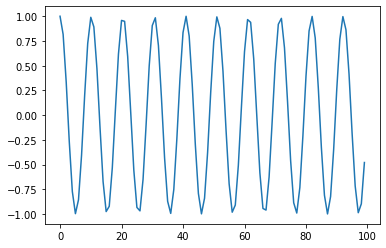

In [ ]:
# x_train,y_train = generate_db_sine_multiple(mu,train_sigma,A,dimension,equations,n,min_freq,max_freq,num_of_waves)
y_unmodified,x_train,y_train = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,2,A,cardinality)
print(x_train.shape,len(y_train),len(y_train[0]),len(y_train[0][0]),len(y_unmodified),len(y_unmodified[0]))
print(x_train[1])
plt.plot(x_train[1])

In [ ]:
'''
# The model
def model_noise(x,y,x_test,y_test):
  
  
  y_in = keras.Input(shape=(equations))
  ly = keras.layers.Dense(equations*8, activation='relu')(y_in)# input_shape=[equations+ dimension*equations]),
  y_out = keras.layers.Dense(equations*4, activation='relu')(ly)
  # modely = keras.Model(inputs=y_in, outputs=y_out, name="y_model")
  
  A_in = keras.Input(shape=(dimension*equations))
  lA = keras.layers.Dense(dimension*equations/2, activation='relu')(A_in)# input_shape=[equations+ dimension*equations]),
  A_out = keras.layers.Dense(dimension*equations/100, activation='relu')(lA)# input_shape=[equations+ dimension*equations]),
  # modelA = keras.Model(inputs=A_in, outputs=A_out, name="A_model")
  # print(modely.output.shape,modelA.output.shape)
  combined = tf.keras.layers.concatenate([y_out, A_out])

  lc1 = keras.layers.Dense(dimension*8, activation='relu')(combined)
  lc2 = keras.layers.Dense(dimension*4, activation='relu')(lc1)
    # keras.layers.Dense(dimension, activation='sigmoid') # for sparse 1 0 output
  c_out = keras.layers.Dense(dimension, activation='linear')(lc2) # for sparse 1 0 output
  modelC = keras.Model(inputs=[y_in,A_in], outputs=c_out, name="c_model")

  modelC.compile(loss='mse', optimizer='adam', metrics=['logcosh', 'mse'])
  
  Aa= np.array(A)
  A1 = np.reshape(Aa,(1,dimension*equations))
  temp = np.ones(y.shape[0])
  temp = np.reshape(temp,(y.shape[0],1))
  temp = temp*A1
  temp2 = np.ones(y_test.shape[0])
  temp2 = np.reshape(temp2,(y_test.shape[0],1))
  temp2 = temp2*A1
  print("hello: " ,y.shape,temp.shape)
  z = [y,temp]
  print(len(z),len(z[0]),len(z[0][0]),len(z[1][0]))
  history = modelC.fit([y,temp], x,validation_data=([y_test,temp2],x_test), epochs=200,verbose=0)
  print(modelC.summary())

  #evaluating on trained noise data
  # eval_train_noise = model.evaluate(y[-eval_n:],x[-eval_n:],verbose=0)

  #evaluating on high noise data
  # diff = np.square(high_noise_data[0] - model.predict(high_noise_data[1]))
  # mse_high_noise = (np.apply_along_axis(np.sum,1,diff))/(dimension)
  
  # return np.average(mse_high_noise), eval_train_noise[0],model,history
  return modelC,history

'''

'\n# The model\ndef model_noise(x,y,x_test,y_test):\n  \n  \n  y_in = keras.Input(shape=(equations))\n  ly = keras.layers.Dense(equations*8, activation=\'relu\')(y_in)# input_shape=[equations+ dimension*equations]),\n  y_out = keras.layers.Dense(equations*4, activation=\'relu\')(ly)\n  # modely = keras.Model(inputs=y_in, outputs=y_out, name="y_model")\n  \n  A_in = keras.Input(shape=(dimension*equations))\n  lA = keras.layers.Dense(dimension*equations/2, activation=\'relu\')(A_in)# input_shape=[equations+ dimension*equations]),\n  A_out = keras.layers.Dense(dimension*equations/100, activation=\'relu\')(lA)# input_shape=[equations+ dimension*equations]),\n  # modelA = keras.Model(inputs=A_in, outputs=A_out, name="A_model")\n  # print(modely.output.shape,modelA.output.shape)\n  combined = tf.keras.layers.concatenate([y_out, A_out])\n\n  lc1 = keras.layers.Dense(dimension*8, activation=\'relu\')(combined)\n  lc2 = keras.layers.Dense(dimension*4, activation=\'relu\')(lc1)\n    # keras.laye

In [ ]:
# def custom_mse(y_true, y_pred):
#         return K.square(K.mean(K.square(y_pred - y_true)))
# The model
def model_noise(x,y,x_test,y_test):
  layers = []
  inputs = []
  lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.05)
  for i in range(0,equations):
    input_l  = keras.Input(shape=[dimension+1], name='input{0}'.format(i))  
    f1 = keras.layers.Dense(dimension*4, activation=lrelu)(input_l)
    # f2 = keras.layers.Dense(dimension*8, activation=lrelu)(f1)
    # f3 = keras.layers.Dense(dimension*4, activation=lrelu)(f2)
    f4 = keras.layers.Dense(dimension*4, activation=lrelu)(f1)
    y_out = keras.layers.Dense(dimension*2, activation=lrelu)(f4)
    layers.append(y_out)
    inputs.append(input_l)
  
  added_layer = keras.layers.Average()(layers)
  # print(len(layers),layers[0].shape)
  # print(len(inputs),inputs[0].shape)
  print(num_of_waves, "in func")

  lc1 = keras.layers.Dense(dimension*8, activation=lrelu)(added_layer)
  lc2 = keras.layers.Dense(dimension*4, activation= lrelu)(lc1)
  lc3 = keras.layers.Dense(dimension*2, activation= lrelu)(lc2)
  lc4 = keras.layers.Dense(dimension*2, activation= lrelu)(lc3)
  # keras.layers.Dense(dimension, activation='sigmoid') # for sparse 1 0 output
  c_out = keras.layers.Dense(dimension, activation='linear')(lc4) # for sparse 1 0 output
  
  modelC = keras.Model(inputs = inputs,outputs = c_out, name="c_model")
  # opt = keras.optimizers.Adam(learning_rate=0.001,decay = 0.001)
  modelC.compile(loss="mse", optimizer='adam', metrics=['logcosh', 'mse'])
  #--------Set up data
  # print(modelC.summary())
  from keras.utils.vis_utils import plot_model
  plot_model(modelC, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience = 100, min_delta = 0.001)
  history = modelC.fit([y], x,validation_data=(y_test,x_test),batch_size = 5000, epochs=2000,verbose=0,callbacks= [es])
 

  #evaluating on trained noise data
  # eval_train_noise = model.evaluate(y[-eval_n:],x[-eval_n:],verbose=0)

  #evaluating on high noise data
  # diff = np.square(high_noise_data[0] - model.predict(high_noise_data[1]))
  # mse_high_noise = (np.apply_along_axis(np.sum,1,diff))/(dimension)
  
  # return np.average(mse_high_noise), eval_train_noise[0],model,history
  return modelC,history



In [ ]:
# #Plotting
# plt.plot(sigmas,high_noise_mses,'b-',label = "Low noise ")
# plt.plot(sigmas,train_noise_mses,'r-',label = "Training noise ")
# plt.ylabel('MSE of Error')
# plt.xlabel('Sigma')
# plt.legend()
# # plt.savefig('0_1_to_1_gaussian_0.05.png')


In [ ]:
# Train model 
def model_it(cardinality):
  
  tick1 = time.time()
  _,x_train,y_train = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,n,A,cardinality)
  # x_test,y_test = generate_db_sine_multiple(mu,test_sigma,A,dimension,equations,eval_n,min_freq,max_freq,num_of_waves)
  y_unmodified,x_test,y_test = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,eval_n,A,cardinality)
  # print(x_train.shape,y_train.shape)
  # print(x_t est.shape,y_test.shape)
  model,history = model_noise(x_train,y_train,x_test,y_test)
  tock1 = time.time()
  print(tock1-tick1)

  ## SAVE MODEL
  model.save("model.h5")
  return model,history, x_test,y_test,y_unmodified
 
# model,history, x_test,y_test = model_it(cardinality)

In [ ]:
## LOAD model
# from keras.models import load_model
# model = load_model('model.h5')


In [ ]:
# Plot loss(mse)

# plt.plot(history.history['loss'][100:2000])
# plt.plot(history.history['val_loss'][100:2000])


In [ ]:
#Metrics evaluation of model trained
#Seeing just one example sine wave
# x = np.empty((1,dimension), dtype = np.float32)
# y = np.empty((1,equations), dtype = np.float32)
# x,y = generate_db_sparse(mu,train_sigma,10 ,dimension,equations,1,A)

#Test analysis
"""
test_n = 5000
x = np.empty((test_n,dimension), dtype = np.float32)
y = np.empty((test_n,equations), dtype = np.float32)
_,x,y = generate_db_sparse(mu,train_sigma,10 ,dimension,equations,test_n,A)
x1 = model.predict(y)

print("mse of example :",((x1-x[0])**2).mean())
print((x[0]).astype(int),"\n",(np.round(x1[0])).astype(int))
plt.plot(x[0],'r.',(x1[0]),'b')


#complete metric
print("Training loss   :",history.history["loss"][-1])
print("Validation loss :", history.history["val_loss"][-1])
"""
# Red is noise free input, Blue is predicted by model 

'\ntest_n = 5000\nx = np.empty((test_n,dimension), dtype = np.float32)\ny = np.empty((test_n,equations), dtype = np.float32)\n_,x,y = generate_db_sparse(mu,train_sigma,10 ,dimension,equations,test_n,A)\nx1 = model.predict(y)\n\nprint("mse of example :",((x1-x[0])**2).mean())\nprint((x[0]).astype(int),"\n",(np.round(x1[0])).astype(int))\nplt.plot(x[0],\'r.\',(x1[0]),\'b\')\n\n\n#complete metric\nprint("Training loss   :",history.history["loss"][-1])\nprint("Validation loss :", history.history["val_loss"][-1])\n'

In [ ]:
#analysis using x and x1 , to find which all values are correctly classified
# x(true)   x1(predicted)
# for i in range(test_n):
# x = x/4
# x1 = np.round(x1/4)
"""
x1 = np.multiply((x1>0),x1)
z = np.multiply((x==x1).astype(int),x.astype(int))
unique_elements_true, counts_elements_true = np.unique(x.astype(int), return_counts=True)
unique_elements_predicted, counts_elements_predicted= np.unique(z, return_counts=True)
print("exact value analysis")
print(unique_elements_true, counts_elements_true)
print(unique_elements_predicted, counts_elements_predicted)
print(unique_elements_predicted, counts_elements_predicted/counts_elements_true)


#sparseness analysis
print("Sparse value analysis")
s = (x>0).astype(int)
s1 = (x1>0).astype(int)
tp = np.logical_and((s==s1),(1)).astype(int)
# fp = np.logical_and((s==s1),(s==0)).astype(int)
sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
print(sparse_unique_elements_true, sparse_counts_elements_true)
print(sparse_unique_elements_predicted, sparse_counts_elements_predicted/(test_n*dimension))
print(sparse_unique_elements_predicted, sparse_counts_elements_predicted/sparse_counts_elements_true)

# print((x[1]).astype(int))
print()
"""



'\nx1 = np.multiply((x1>0),x1)\nz = np.multiply((x==x1).astype(int),x.astype(int))\nunique_elements_true, counts_elements_true = np.unique(x.astype(int), return_counts=True)\nunique_elements_predicted, counts_elements_predicted= np.unique(z, return_counts=True)\nprint("exact value analysis")\nprint(unique_elements_true, counts_elements_true)\nprint(unique_elements_predicted, counts_elements_predicted)\nprint(unique_elements_predicted, counts_elements_predicted/counts_elements_true)\n\n\n#sparseness analysis\nprint("Sparse value analysis")\ns = (x>0).astype(int)\ns1 = (x1>0).astype(int)\ntp = np.logical_and((s==s1),(1)).astype(int)\n# fp = np.logical_and((s==s1),(s==0)).astype(int)\nsparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)\nsparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)\nprint(sparse_unique_elements_true, sparse_counts_elements_true)\nprint(sparse_unique_elements_predict

In [ ]:
"""model,history, x_test,y_test,y_unmodified = model_it(10)
print("Training loss   :",history.history["loss"][-1])
print("Validation loss :", history.history["val_loss"][-1])"""

'model,history, x_test,y_test,y_unmodified = model_it(10)\nprint("Training loss   :",history.history["loss"][-1])\nprint("Validation loss :", history.history["val_loss"][-1])'

In [ ]:
"""# Construct the problem.

x = cp.Variable(dimension)
objective = cp.Minimize(cp.atoms.norm1(x))
y = y_unmodified[0]
constraints = [A@x==y]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
basis_x1 = x.value
basis_x1 = np.round(basis_x1)
basis_x = np.multiply((basis_x1>0),basis_x1)
basis_x = (basis_x>0).astype(int)
print(basis_x,"\n",x_test[0].astype(int))"""

'# Construct the problem.\n\nx = cp.Variable(dimension)\nobjective = cp.Minimize(cp.atoms.norm1(x))\ny = y_unmodified[0]\nconstraints = [A@x==y]\nprob = cp.Problem(objective, constraints)\n\n# The optimal objective value is returned by `prob.solve()`.\nresult = prob.solve()\n# The optimal value for x is stored in `x.value`.\nbasis_x1 = x.value\nbasis_x1 = np.round(basis_x1)\nbasis_x = np.multiply((basis_x1>0),basis_x1)\nbasis_x = (basis_x>0).astype(int)\nprint(basis_x,"\n",x_test[0].astype(int))'

In [ ]:
# for i in range(2,11):
#   print("Cardinality: ",i)
#   model,history, x_test,y_test = model_it(i)
#   print("Training loss   :",history.history["loss"][-1])
#   print("Validation loss :", history.history["val_loss"][-1])
#   x1 = model.predict(y_test)
#   x1 = np.round(np.multiply((x1>0),x1))  
#   s = (x_test>0).astype(int)
#   s1 = (x1>0).astype(int)
#   tp = np.logical_and((s==s1),(1)).astype(int)
#   sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
#   sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
#   print("Percentage Accuracy: [Wrong,Right]:" ,100* sparse_counts_elements_predicted/(test_n*dimension))
#   print("\n")
# print(model)
"""
for i in range(1,11):
  print("Multiplier: ",i)
  multiplier = i
  model,history, x_test,y_test = model_it(10)
  print("Training loss   :",history.history["loss"][-1])
  print("Validation loss :", history.history["val_loss"][-1])
  x1 = model.predict(y_test)
  x_test = x_test/i
  x1 = x1/i
  x1 = np.round(x1)
  x1 = np.multiply((x1>0),x1)  
  s = (x_test>0).astype(int)
  s1 = (x1>0).astype(int)
  tp = np.logical_and((s==s1),(1)).astype(int)
  sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
  sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
  print("Percentage Accuracy: [Wrong,Right]:" ,100* sparse_counts_elements_predicted/(test_n*dimension))
  print("\n")
"""
train_dat=[]
valid_dat = []
time_model_dat =[]
time_omp_dat =[]
time_basis_dat =[]
mse_model_dat=[]
mse_omp_dat =[]
mse_basis_dat =[]


for i in range(1,20):
  # num_of_waves = int(i*5*dimension/100)
  num_of_waves = 40+i*5
  model,history, x_test,y_test,y_unmodified = model_it(10)
  print("Training loss   :",history.history["loss"][-1])
  print("Validation loss :", history.history["val_loss"][-1])
  # y_unmodified,x_test,y_test = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,1,A,cardinality)
  # print(x_test)
  y_unmodified,x_test,y_test = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,10000,A,cardinality)
  tick1 = time.time()
  model_x1 = model.predict(y_test)
  # tem = np.argpartition(model_x1, -10)[:,:-10]
  # for i in range(len(model_x1)):
    # model_x1[i][tem[i]] = 0
  tock1 = time.time()
  time_model = tock1-tick1
  print(tock1-tick1)
  """
  omp = OrthogonalMatchingPursuit(n_nonzero_coefs=num_of_waves)
  tick1 = time.time()
  omp.fit(A, np.transpose(y_unmodified))
  tock1 = time.time()
  time_omp = tock1-tick1
  print(tock1-tick1)
  omp_x1= omp.coef_

  basis_x1 = np.copy(model_x1)
  tick1 = time.time()
  for i in range(len(y_unmodified)):
    x = cp.Variable(dimension)
    objective = cp.Minimize(cp.atoms.norm1(x))
    y = y_unmodified[i]
    constraints = [A@x==y]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    basis_x1[i] = x.value
  tock1 = time.time()
  time_basis = tock1-tick1
  print(tock1-tick1)
  """

  # model_x1 = np.round(model_x1)
  # model_x = np.multiply((model_x1>0),model_x1)
  # omp_x = np.round(omp_x1)
  # omp_x = np.multiply((omp_x>0),omp_x)
  # basis_x1 = np.round(basis_x1)
  # basis_x = np.multiply((basis_x1>0),basis_x1)

  true_x = x_test
  model_x = model_x1
  # omp_x = omp_x1
  # basis_x = basis_x1


  # print(true_x[1],omp_x[1])
  # print(np.dot(A,x_test[1]),y_unmodified[1])

  ##SNR model
  mse_model = (np.square(true_x-model_x)).mean(axis=1)
  ##SNR omp
  # mse_omp = (np.square(true_x-omp_x)).mean(axis=1)
  ##SNR basis
  # mse_basis = (np.square(true_x-basis_x)).mean(axis=1)
  
  # print(mse_model.mean(),mse_omp.mean(),mse_basis.mean())
  print("\n")
  train_dat.append(history.history["loss"][-1])
  valid_dat.append(history.history["val_loss"][-1])
  time_model_dat.append(time_model)
  # time_omp_dat.append(time_omp)
  # time_basis_dat.append(time_basis)
  mse_model_dat.append(mse_model.mean())
  # mse_omp_dat.append(mse_omp.mean())
  # mse_basis_dat.append(mse_basis.mean())
# print(train_dat,valid_dat,time_model_dat,time_omp_dat,time_basis_dat,mse_model_dat,mse_omp_dat,mse_basis_dat)
print(train_dat,valid_dat,time_model_dat,mse_model_dat)

45 in func
Epoch 00236: early stopping
130.95859956741333
Training loss   : 0.0013657324016094208
Validation loss : 0.0017718803137540817
3.758227586746216


50 in func
Epoch 00267: early stopping
151.01312255859375
Training loss   : 0.00038938323268666863
Validation loss : 0.0004078835481777787
4.273745536804199


55 in func
Epoch 00213: early stopping
123.15769481658936
Training loss   : 0.0010856640292331576
Validation loss : 0.0016339103458449244
3.7994487285614014


60 in func
Epoch 00197: early stopping
114.96319460868835
Training loss   : 0.0005702102789655328
Validation loss : 0.0016169305890798569
4.265896797180176


65 in func
Epoch 00223: early stopping
129.48038506507874
Training loss   : 0.00029764798819087446
Validation loss : 0.00030669933767057955
3.8799808025360107


70 in func
Epoch 00251: early stopping
144.4110231399536
Training loss   : 0.0013394952984526753
Validation loss : 0.001977174775674939
4.328280448913574


75 in func
Epoch 00272: early stopping
155.710756

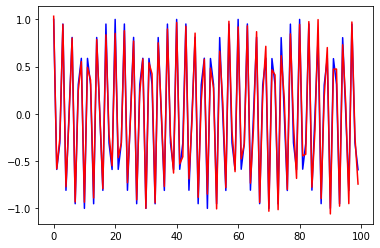

In [ ]:
# time_model_dat1 =      [3.14  ,3.18, 3.29, 3.2, 3.14,3.13, 3.19, 3.2, 3.21, 3.15, 3.3, 3.16, 3.2, 3.2, 3.29,3.2,3.61,3.12, 
# time_omp_dat1 =        [0.78,1.55, 2.27, 3.17,3.78, 4.75, 5.29, 6.24,6.89, 7.67, 8.95, 9.56,10.2, 11.6, 12.29,13.4,14.26,15.12, 
# time_basis_dat1 =      [103.11,105,105.5,105.8,106.7,106.9,107.2,107.5,108.22,109.4,108.7,108.7,107.75,107.28,106.23, 104.6,103.2,103.9, 
# snr_model_dat1=        [16.16,18.16, 15.35, 15.27, 15.51,16.16, 15.6, 15.15, 14.72, 14.41, 14.25, 14.0,13.9,13.81,13.7,13.66, 13.58, 13.55, 
# snr_omp_dat1 =         [16.76,21.16, 23.87, 25.82, 27.07, 27.64, 27.5, 26.45, 24.35, 21.7, 19.18, 16.6, 14.8,13.79,13.2,13, 12.9, 12.86, 
# snr_basis_dat1 =       [16.76,21.16, 23.91, 26.04, 27.67, 29.07, 30.27, 31.31, 32.24, 33, 33.4, 33.37, 32.52,30.32,27.16,23.7, 20.4,18.02, 




"""
# Sine
Epoch 00304: early stopping
200.14930534362793
Training loss   : 0.0005038141389377415
Validation loss : 0.0007054130546748638
2.9988889694213867
2.145569086074829
100.73453378677368
13.513075909229764 12.779604439835 13.67155399557933


[0.0005038141389377415] [0.0007054130546748638] [2.9988889694213867] [2.145569086074829] [100.73453378677368] [13.513075909229764] [12.779604439835] [13.67155399557933]
"""
# time_model_dat = time_model_dat1 +time_model_dat 
# time_omp_dat =time_omp_dat1+time_omp_dat
# time_basis_dat = time_basis_dat1+time_basis_dat
# snr_model_dat = snr_model_dat1 +snr_model_dat
# snr_omp_dat = snr_omp_dat1+snr_omp_dat
# snr_basis_dat = snr_basis_dat1+snr_basis_dat
# model_x1 = model.predict(y_test)
plt.plot(x_test[10],'b',model_x1[10],'r')
# mse_model = (np.square(true_x-model_x)).mean(axis=1)
# ##SNR omp
# mse_omp = (np.square(true_x-omp_x)).mean(axis=1)
# ##SNR basis
# mse_basis = (np.square(true_x-basis_x)).mean(axis=1)
# print(mse_model.mean(),mse_omp.mean(),mse_basis.mean())
# print(train_dat,valid_dat,time_model_dat,time_omp_dat,time_basis_dat,mse_model_dat,mse_omp_dat,mse_basis_dat)


[ 40  45  50  55  60  65  70  75  80  85  90  95 100 105 110 115 120 125
 130]


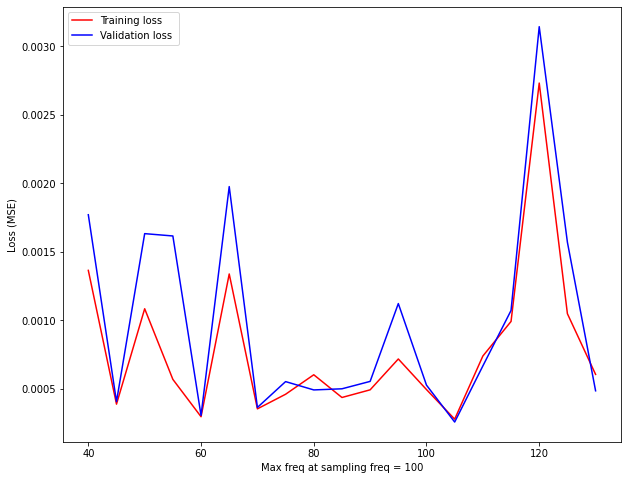

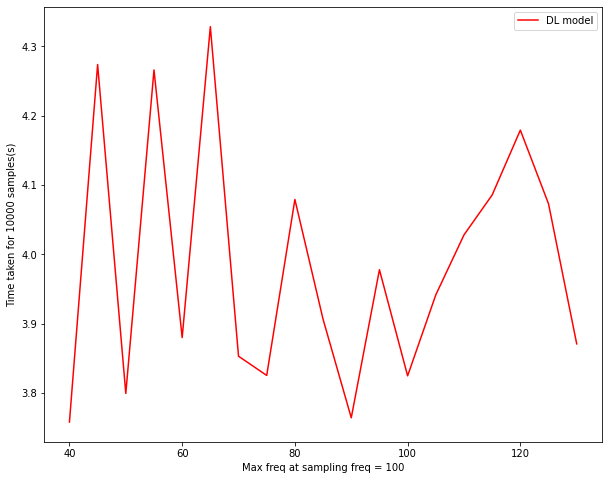

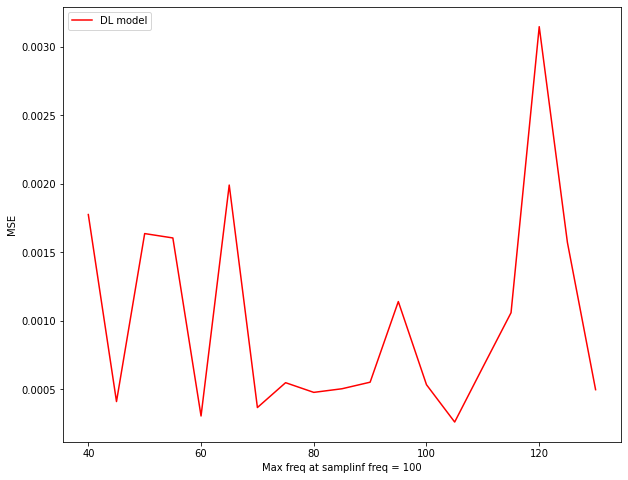

In [ ]:
# print(x_test[-1],model_x[-1])
# print(snr_model.shape,snr_omp.shape)
# print(snr_model.sum())
# print(model_x[1])
# print(omp_x[1])

# plt.plot(np.arange(10000),(snr_model),'b')
# plt.figure()
# plt.plot(np.arange(10000),(snr_omp),'r')

# print(model_x1[1])
# tem = np.argpartition(model_x1, -10)[:,:-10]
# for i in range(len(model_x1)):
#   model_x1[i][tem[i]] = 0
# model_x1[tem] = 0
# print(model_x1[1])
indices = np.arange(40,135,5)
# train_dat =           [0.0017418210627511144, 0.0004660587292164564, 0.0001921313814818859, 0.00012872171646449715, 0.0012522628530859947, 0.0004008385294582695, 0.0003214406024198979, 0.0021910120267421007, 0.0005458318046294153, 0.0008428655564785004, 0.000585753470659256, 0.001131520257331431] 
# valid_dat =           [0.0027469596825540066, 0.000612441566772759, 0.00020041318202856928, 0.00013084799866192043, 0.001308310660533607, 0.0004258294065948576, 0.0003644533280748874, 0.0016055423766374588, 0.000654504750855267, 0.0015277222264558077, 0.0006243658717721701, 0.0006582745118066669] 
# time_model_dat =      [3.6084444522857666, 3.5532724857330322, 3.6407501697540283, 3.96657395362854, 4.163311719894409, 3.554004669189453, 3.9436287879943848, 3.8135383129119873, 3.8804080486297607, 3.6799142360687256, 3.6713995933532715, 3.8480348587036133] 
# time_omp_dat =        [19.595450401306152, 22.94502019882202, 21.63256859779358, 22.169535875320435, 21.98813819885254, 21.715625286102295, 21.892168521881104, 22.040801763534546, 22.16184377670288, 21.521461486816406, 21.439048290252686, 22.64409589767456] 
# time_basis_dat =      [98.90320467948914, 98.85943078994751, 99.37903594970703, 98.817626953125, 98.57897400856018, 99.62358140945435, 98.90683817863464, 99.01050591468811, 99.00170826911926, 99.5781922340393, 99.85417747497559, 99.98117423057556] 
# snr_model_dat=        [0.0027474682, 0.00060888665, 0.00019205111, 0.00012820908, 0.0013123717, 0.00042722453, 0.00037731248, 0.001612354, 0.00065355946, 0.001527443, 0.00060981384, 0.0006558999] 
# snr_omp_dat =         [0.8881854633729804, 1.5094394183621842, 1.5445177987622418, 1.6278958575148186, 1.5539652508297603, 1.638035467571516, 1.681358740330629, 1.6502315751908376, 1.5657534859538882, 1.6247800611238892, 1.5151196420833974, 1.5771051740567472] 
# snr_basis_dat =       [0.44176456, 0.44840166, 0.45149007, 0.44756743, 0.4515283, 0.447278, 0.4421502, 0.44211012, 0.4443435, 0.441502, 0.4368999, 0.44683686]
# perfect_recon_snr = 20*np.log(np.sqrt(indices*dimension/100)+1)
print(indices)
plt.figure(figsize=(10, 8))
plt.plot(indices,train_dat,'r-',label = "Training loss ")
plt.plot(indices,valid_dat,'b-',label = "Validation loss ")
plt.ylabel('Loss (MSE)')
plt.xlabel('Max freq at sampling freq = 100')
plt.legend()

plt.figure(figsize=(10, 8))
plt.plot(indices,time_model_dat,'r-',label = "DL model")
# plt.plot(indices,time_omp_dat,'b-',label = "OMP")
# plt.plot(indices,time_basis_dat,'g-',label = "Basis")
plt.ylabel('Time taken for 10000 samples(s)')
plt.xlabel('Max freq at sampling freq = 100')
plt.legend()

plt.figure(figsize=(10, 8))
plt.plot(indices,mse_model_dat,'r-',label = "DL model")
# plt.plot(indices,mse_omp_dat,'b-',label = "OMP")
# plt.plot(indices,mse_basis_dat,'g-',label = "Basis")
# plt.plot(indices,perfect_recon_snr,'k-',label = "perfect_snr")
plt.ylabel('MSE')
plt.xlabel('Max freq at samplinf freq = 100')
plt.legend()


Cardinality:  2
Epoch 00879: early stopping
379.96951246261597
Training loss   : 0.002135766204446554
Validation loss : 0.0038868251722306013
Percentage Accuracy: [Wrong,Right]: [9.000e-02 9.991e+01]


Cardinality:  3
Epoch 01044: early stopping
448.4506371021271
Training loss   : 0.006050974130630493
Validation loss : 0.013447360135614872
Percentage Accuracy: [Wrong,Right]: [ 0.5308 99.4692]


Cardinality:  4
512.6081898212433
Training loss   : 0.011856448836624622
Validation loss : 0.028034768998622894
Percentage Accuracy: [Wrong,Right]: [ 1.201 98.799]


Cardinality:  5
513.373165845871
Training loss   : 0.019076654687523842
Validation loss : 0.049769770354032516
Percentage Accuracy: [Wrong,Right]: [ 2.0802 97.9198]


Cardinality:  6
512.4558897018433
Training loss   : 0.029436489567160606
Validation loss : 0.07413434982299805
Percentage Accuracy: [Wrong,Right]: [ 3. 97.]


Cardinality:  7
512.4523162841797
Training loss   : 0.03945969417691231
Validation loss : 0.10321462154388428
Percentage Accuracy: [Wrong,Right]: [ 4.1094 95.8906]


Cardinality:  8
513.3301746845245
Training loss   : 0.05366307497024536
Validation loss : 0.14584973454475403
Percentage Accuracy: [Wrong,Right]: [ 5.403 94.597]


Cardinality:  9
512.0672745704651
Training loss   : 0.07128644734621048
Validation loss : 0.17760775983333588
Percentage Accuracy: [Wrong,Right]: [ 6.576 93.424]


Cardinality:  10
513.6596004962921
Training loss   : 0.08878307789564133
Validation loss : 0.2388237863779068
Percentage Accuracy: [Wrong,Right]: [ 8.5418 91.4582]



1 Hidden layer neural network with 4*dimension number of nodes.

|Waves| Dimensions   |      Equations      |  train sigma | test sigma |train loss(mse) | test loss | loss on sine wave | Visual obs|
|-----:|----------|:-------------:|------:|-------:| -------:|------------:|------------:|-------:|
|1| 100 |  100| 0.01 |0.2|0.00096|0.00069|0.01327 |Acceptable
|2| 100 |  100| 0.01 |0.2|0.00912|0.01479|0.04617 |Acceptable
|3| 100 |  100| 0.01 |0.2|0.01499|0.01059|0.09541 |Single sine results are wavier but acceptable
|4| 100 |  100| 0.01 |0.2|0.02960|0.01541|0.07621 |similar to 3
|5| 100 |  100| 0.01 |0.2|0.04723|0.02506|0.23794 |similar to 3
|6| 100 |  100| 0.01 |0.2|0.05250|0.04264|0.18312 |similar to 3 + bad predictions for 1-2 waves
|7| 100 |  100| 0.01 |0.2|0.05741|0.03608|0.21407 |similar to 6 
|8| 100 |  100| 0.01 |0.2|0.05123|0.06004|0.22249 |similar to 6 






2 Hidden layer neural network with 4\*dimension number of nodes in first and 2\*dimension in second layer.

|Waves| Dimensions   |      Equations      |  train sigma | test sigma |train loss(mse) | test loss | loss on sine wave | Visual obs|
|-----:|----------|:-------------:|------:|-------:| -------:|------------:|------------:|-------:|
|1| 100 |  100| 0.01 |0.2|0.00049|0.00085|0.00086 |Acceptable
|2| 100 |  100| 0.01 |0.2|0.01416|0.00934|0.00768 |1 layer was better ,Acceptable
|3| 100 |  100| 0.01 |0.2|0.01610|0.02042|0.04245 |1 layer model was better but single sine is better here
|4| 100 |  100| 0.01 |0.2|0.02194|0.02873|0.10675 |similar to 3
|5| 100 |  100| 0.01 |0.2|0.03140|0.02925|0.10590 |acceptable , less similar to 3
|6| 100 |  100| 0.01 |0.2|0.03668|0.04846|0.08422 |similar to 3 + bad predictions for 1-2 waves
|7| 100 |  100| 0.01 |0.2|0.03654|0.05338|0.10207 |similar to 6 
|8| 100 |  100| 0.01 |0.2|0.05968|0.07704|0.23905 |similar to 6 


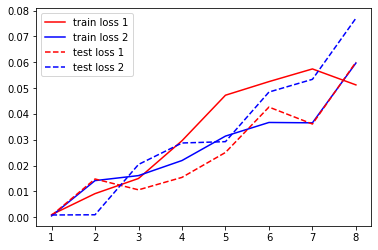

In [ ]:
train_loss1 = [0.00096,0.00912,0.01499,0.02960,0.04723,0.05250,0.05741,0.05123]
test_loss1 = [0.00069,0.01479,0.01059,0.01541,0.02506,0.04264,0.03608,0.06004]
train_loss2 = [0.00049,0.01416,0.01610,0.02194,0.03140,0.03668,0.03654,0.05968]
test_loss2 = [0.00085,0.000934,0.02042,0.02873,0.02925,0.04846,0.05338,0.07704]
sine_loss1=[0.01327,0.04617,0.09541,0.07621,0.023794,0.18312,0.21407,0.22249]
sine_loss2 = [0.00086,0.00768,0.04245,0.10675,0.10590,0.08422,0.10207,0.23905]
numb_of_waves = np.arange(1,9)
import matplotlib.pyplot as plt
plt.plot(numb_of_waves,train_loss1,'r-',label= "train loss 1")
# plt.plot(numb_of_waves,sine_loss1,'r.-',label ="sine loss 1")
plt.plot(numb_of_waves,train_loss2,'b-',label = "train loss 2")
plt.plot(numb_of_waves,test_loss1,'r--',label= "test loss 1")
plt.plot(numb_of_waves,test_loss2,'b--',label = "test loss 2")
# plt.plot(numb_of_waves,sine_loss2,'b.-',label = "sine loss 2")
plt.legend()

In [ ]:
# Random Codes
'''

print(x)
with open('dbx', 'rb') as f:
  meh = np.load(f,allow_pickle=True) 
print(np.shape(x))
print(np.shape(np.transpose(y[80])))
print(x)
print(y[80])
print((y[80].reshape(3)))
a =[[1.0421941],[0.8363143], [0.7082898]]
print(((avg_error_norm)**2)/(dimension),avg_mse)

'''

# temp = [[-4, -3, -2],
#        [-1,  0,  1],
#        [ 2,  3,  4]]

# temp2 = list(filter(lambda x: print(np.sum(x),"\n") ,temp))
# np.sum(temp2)
# print(np.sum(temp[0]))
# print(np.square(temp).mean())
# x,_ = generate_db_sine_multiple(mu,test_sigma,A,dimension,equations,1,min_freq,max_freq,1)
# print(x)

"\n\nprint(x)\nwith open('dbx', 'rb') as f:\n  meh = np.load(f,allow_pickle=True) \nprint(np.shape(x))\nprint(np.shape(np.transpose(y[80])))\nprint(x)\nprint(y[80])\nprint((y[80].reshape(3)))\na =[[1.0421941],[0.8363143], [0.7082898]]\nprint(((avg_error_norm)**2)/(dimension),avg_mse)\n\n"

In [ ]:
# #trying inverse using A Recurrent Neural Network for Real-Time Matrix Inversion* -Jun Wang
import numpy as np
# row = 4;col =5
# A = np.random.rand(row,row)
# A1 = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
# # dv = np.zeros((row,col), dtype=int)
# v = np.zeros((row,row), dtype=float)
# ya = np.array([13,14,15],[16,17,18])
# ya= ya.reshape(3,1)
# print(A1,ya)
# A1 = np.append(A1,ya,axis=1)
# print(A1.reshape(1,15))
be = [1,2,3]
ce = [3,4,5]
de = [be,ce,be,be]
print(len(be), len(de),len(de[0]))
abc = np.random.rand(4,3)
defg = [abc,abc]
# defg = [defg,defg]
print(len(defg),len(defg[0]),len(defg[0][0]))
print(defg)
# print(y.reshape(3,1))

# eps = 1e-6
# n =10000
# delta = 1e4
# AT = delta*A.T
# # temp = -delta*np.matmul(A.T,A)
# A_inv = np.linalg.inv(A)
# I= np.eye(row, dtype=float)
# while n:
#   v = v- np.matmul(AT,np.arctan(np.matmul(A,v)-I ))
#   # print(np.linalg.norm(A_inv-v),"\n")
#   n-=1
# print(A,"\n\n",I  ,"\n\n",v,"\n\n",A_inv)
# S = random(1, 10, density=4/10)
# print(1*(S.A[0]>0))

3 4 3
2 4 3
[array([[0.06191327, 0.53775565, 0.19789607],
       [0.01667334, 0.49347857, 0.31309123],
       [0.65267743, 0.34244972, 0.33880261],
       [0.23323559, 0.55647654, 0.57203624]]), array([[0.06191327, 0.53775565, 0.19789607],
       [0.01667334, 0.49347857, 0.31309123],
       [0.65267743, 0.34244972, 0.33880261],
       [0.23323559, 0.55647654, 0.57203624]])]
